## Import libraries

In [67]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import keras
from sklearn import metrics
import cv2


## Initialise constants

In [68]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # Depth R, G, B


## Prepare training data

In [69]:
image_names = os.listdir(r"C:\Users\jiyon\Downloads\dogs-vs-cats\train\train")
categories = []
for image_name in image_names:
    category = image_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)


In [70]:
df = pd.DataFrame({
    'filename' : image_names,  # columnname, values
    'category': categories  # columnname, values
})

In [71]:
df

filename  category
0         cat.0.jpg         0
1         cat.1.jpg         0
2        cat.10.jpg         0
3       cat.100.jpg         0
4      cat.1000.jpg         0
...             ...       ...
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

[25000 rows x 2 columns]

## Frequency bar graph

<AxesSubplot:xlabel='Cat=0  Dog=1', ylabel='Number of images'>

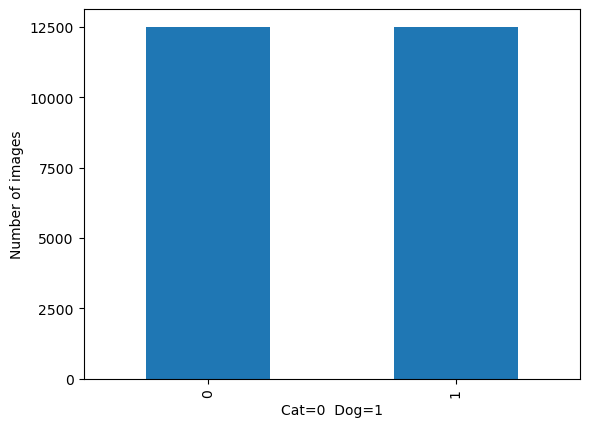

In [72]:
df['category'].value_counts().plot(kind='bar', xlabel='Cat=0  Dog=1', ylabel='Number of images', yticks=np.arange(0, 12501, 2500))

In [73]:
# Checking if number of images are equal
len(df.loc[df['category'] == 0])
# Number of images for cats

12500

In [74]:
len(df.loc[df['category'] == 1])
# Number of images for dogs 

12500

## Load sample image

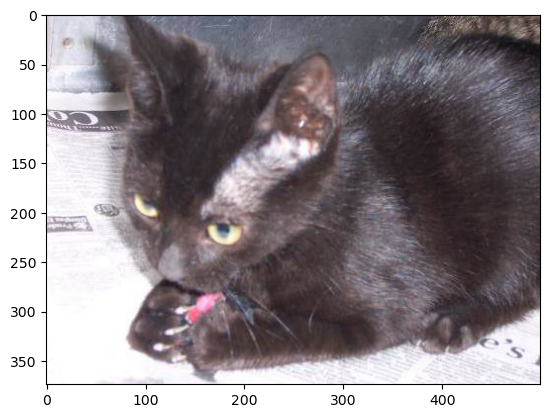

In [75]:
random_img_name = random.choice(image_names)
random_img = plt.imread(r"C:\Users\jiyon\Downloads\dogs-vs-cats\train\train\\" + random_img_name)
plt.imshow(random_img)

In [76]:
random_img

array([[[232, 227, 234],
        [213, 208, 215],
        [209, 204, 211],
        ...,
        [134, 120, 107],
        [137, 123, 110],
        [139, 125, 112]],

       [[233, 228, 235],
        [213, 208, 215],
        [210, 205, 212],
        ...,
        [117, 103,  90],
        [124, 110,  97],
        [129, 115, 102]],

       [[233, 228, 235],
        [214, 209, 216],
        [211, 206, 213],
        ...,
        [123, 111,  99],
        [128, 116, 104],
        [131, 119, 107]],

       ...,

       [[253, 253, 253],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [224, 223, 231],
        [227, 226, 234],
        [230, 229, 237]],

       [[254, 254, 254],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [237, 236, 244],
        [236, 235, 243],
        [235, 234, 242]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [250, 249, 255],
        [246, 245, 253],
        [242, 241, 249]]

## Build Model


In [77]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [78]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))  
# number of filters = 32, kernel size = 3, 3 (kernel size must be odd number) and filters should be a power of 2
model.add(MaxPooling2D(pool_size=(2, 2)))  # is going to half height and width. (32, 64, 64)

# prevent overfitting and increase generalisation
# i will add more conv layers to extract more specific features of the images. So I should increase the number of filters as well.

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Dense(32, activation='relu'))
model.add(Flatten())  # convert 2d array into 1d array
# Ignoeres % of neurons so that a neuron doesn't fix another neurons mistake to
model.add(Dropout(0.4))

model.add(Dense(2, activation='softmax'))  # 2 outputs, dog or cat

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # when preparing the data, we will OHE the categories.
# adam's learning rate is default to 0.001. Will reduce with callbacks later when model gets stuck on minima.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)      

## Callbacks



In [79]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
early_stop = EarlyStopping(monitor="val_loss", patience=15, verbose=1)  # finds minimum in validation loss and runs for another 10 epochs to confirm
filepath = r"C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True, mode='min')
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)
callbacks=[early_stop, checkpoint, log_csv, learning_rate_reduction]

## Prepare Data


In [80]:
df["category"]= df["category"].map({1:'dog', 0:'cat'})
df

filename category
0         cat.0.jpg      cat
1         cat.1.jpg      cat
2        cat.10.jpg      cat
3       cat.100.jpg      cat
4      cat.1000.jpg      cat
...             ...      ...
24995  dog.9995.jpg      dog
24996  dog.9996.jpg      dog
24997  dog.9997.jpg      dog
24998  dog.9998.jpg      dog
24999  dog.9999.jpg      dog

[25000 rows x 2 columns]

In [81]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])  # make validation data
train_df = train_df.reset_index(drop=True)  # reset the index and get rid of old index (old index will be added as column 
# if false)
validation_df = validation_df.reset_index(drop=True)
train_df


filename category
0       dog.5518.jpg      dog
1       cat.3241.jpg      cat
2       dog.9783.jpg      dog
3      dog.11144.jpg      dog
4       dog.5952.jpg      dog
...              ...      ...
19995   dog.7820.jpg      dog
19996   dog.5924.jpg      dog
19997    cat.817.jpg      cat
19998   cat.3395.jpg      cat
19999   dog.8553.jpg      dog

[20000 rows x 2 columns]

<AxesSubplot:xlabel='Cat or Dog', ylabel='Number of images'>

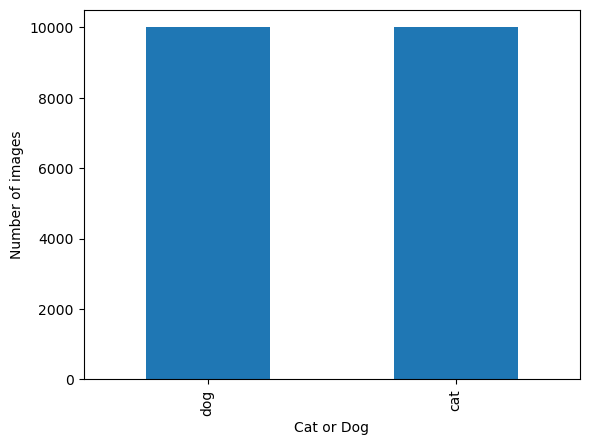

In [82]:
train_df['category'].value_counts().plot(kind='bar', xlabel='Cat or Dog', ylabel='Number of images')

In [83]:
train_df['category'].value_counts()

dog    10000
cat    10000
Name: category, dtype: int64

<AxesSubplot:xlabel='Cat or Dog', ylabel='Number of images'>

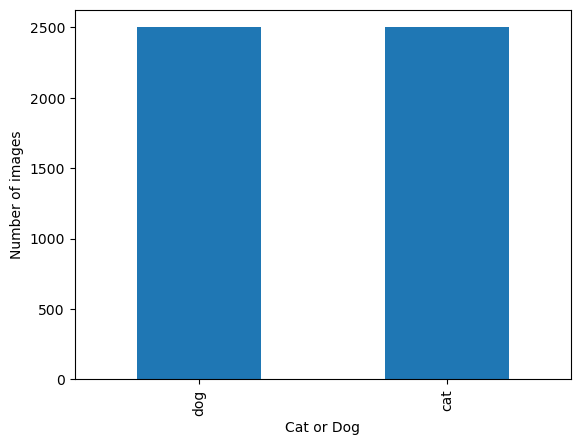

In [84]:
validation_df['category'].value_counts().plot(kind='bar', xlabel='Cat or Dog', ylabel='Number of images')

In [85]:
validation_df['category'].value_counts()

dog    2500
cat    2500
Name: category, dtype: int64

In [86]:
total_train = len(train_df)
total_validation = len(validation_df)
batch_size=15

## Training Generator


We use training generator when there isn't enough data to train the model. We can augment images by flipping, adding different angles, and more for the model to learn from.


In [87]:
train_datagen = ImageDataGenerator(
    rotation_range=15,  # rotate the image up to 15 degrees from original picture
    rescale=1./255,  # resacle pixel values from 0-255 to 0 to 1 (for the model)
    shear_range=0.1,  # distort to add depth and different angles (simulate how humans see from different angles)
    zoom_range = 0.2, # zoom into or out of the image. zoom range (0.8, 1.2)
    horizontal_flip=True,  # flip horizontally
    width_shift_range=0.1,  # shift image horizontally -10% to 10%
    height_shift_range=0.1  # shift image vertically -10% to 10%
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    r"C:\Users\jiyon\Downloads\dogs-vs-cats\train\train\\",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [88]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    r"C:\Users\jiyon\Downloads\dogs-vs-cats\train\train\\",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Testing how generator works:

In [89]:
sample_df = train_df.sample().reset_index(drop=True)  # return 1 sample from df. makes index = 0
sample_generator = train_datagen.flow_from_dataframe(
    sample_df,
    r"C:\Users\jiyon\Downloads\dogs-vs-cats\train\train\\",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'

)
len(sample_generator)

Found 1 validated image filenames belonging to 1 classes.


1

In [90]:
train_df['category'].value_counts()

dog    10000
cat    10000
Name: category, dtype: int64

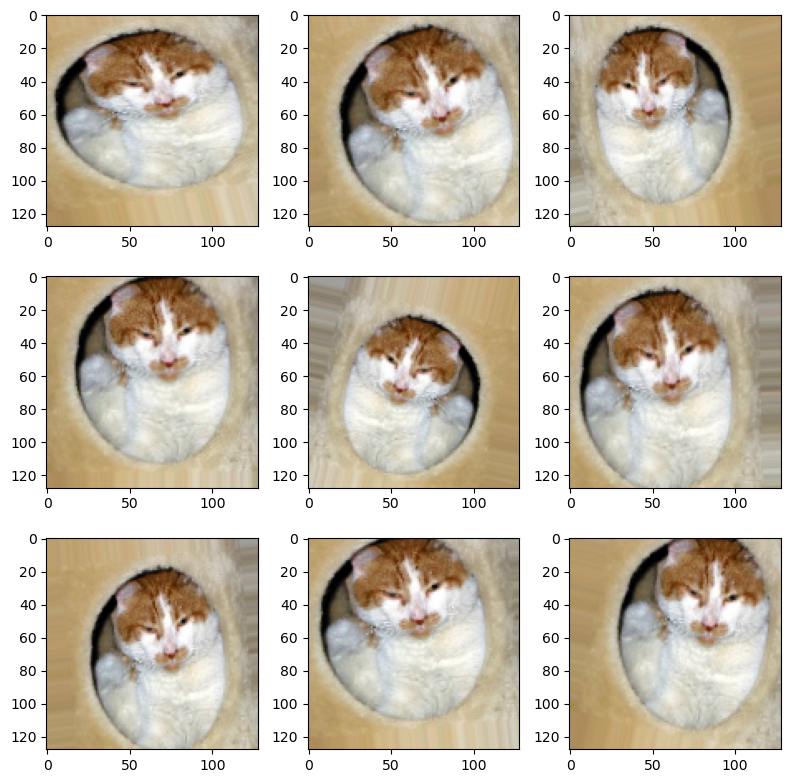

In [91]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for X_batch, y_batch in sample_generator:
        image = X_batch[0]  # for some reason X_batch has an extra layer of list wrapped around it so i need to get the first index (reduce the dimension by 1 less).
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [92]:
total_validation//batch_size

333

## Fit model


In [93]:
epochs = 50
history1 = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5648
Epoch 1: val_loss improved from inf to 0.65869, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 323s 242ms/step - loss: 0.6750 - accuracy: 0.5648 - val_loss: 0.6587 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6566
Epoch 2: val_loss improved from 0.65869 to 0.55273, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 137s 103ms/step - loss: 0.6232 - accuracy: 0.6566 - val_loss: 0.5527 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7062
Epoch 3: val_loss improved from 0.55273 to 0.53479, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 141s 106ms/step - loss: 0.5679 - accuracy: 0.7062 - val_loss: 0.5348 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7337
Epoch 4: val_loss improved from 0.53479 to 0.47799, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 142s 107ms/step - loss: 0.5283 - accuracy: 0.7337 - val_loss: 0.4780 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7562
Epoch 5: val_loss improved from 0.47799 to 0.45042, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 144s 108ms/step - loss: 0.4996 - accuracy: 0.7562 - val_loss: 0.4504 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.7688
Epoch 6: val_loss improved from 0.45042 to 0.40103, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 142s 106ms/step - loss: 0.4816 - accuracy: 0.7688 - val_loss: 0.4010 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 7/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.7879
Epoch 7: val_loss improved from 0.40103 to 0.38779, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 142s 106ms/step - loss: 0.4536 - accuracy: 0.7879 - val_loss: 0.3878 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 8/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.7898
Epoch 8: val_loss did not improve from 0.38779
1333/1333 [==============================] - 140s 105ms/step - loss: 0.4451 - accuracy: 0.7898 - val_loss: 0.3896 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 9/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8027
Epoch 9: val_loss did not improve from 0.38779
1333/1333 [==============================] - 139s 105ms/step - loss: 0.4342 - accuracy: 0.8027 - val_loss: 0.3938 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 10/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8012
Epoch 10: val_loss improved from 0.38779 to 0.38074, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 142s 106ms/step - loss: 0.4297 - accuracy: 0.8012 - val_loss: 0.3807 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 11/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8048
Epoch 11: val_loss improved from 0.38074 to 0.35695, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 143s 107ms/step - loss: 0.4228 - accuracy: 0.8048 - val_loss: 0.3570 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 12/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8108
Epoch 12: val_loss improved from 0.35695 to 0.33991, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 142s 107ms/step - loss: 0.4095 - accuracy: 0.8108 - val_loss: 0.3399 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 13/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.8204
Epoch 13: val_loss did not improve from 0.33991
1333/1333 [==============================] - 141s 106ms/step - loss: 0.4000 - accuracy: 0.8204 - val_loss: 0.3668 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 14/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8210
Epoch 14: val_loss improved from 0.33991 to 0.32469, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 143s 107ms/step - loss: 0.3885 - accuracy: 0.8210 - val_loss: 0.3247 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 15/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8320
Epoch 15: val_loss improved from 0.32469 to 0.31944, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 144s 108ms/step - loss: 0.3810 - accuracy: 0.8320 - val_loss: 0.3194 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 16/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8282
Epoch 16: val_loss did not improve from 0.31944
1333/1333 [==============================] - 143s 107ms/step - loss: 0.3792 - accuracy: 0.8282 - val_loss: 0.3440 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 17/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8316
Epoch 17: val_loss improved from 0.31944 to 0.31938, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 141s 105ms/step - loss: 0.3742 - accuracy: 0.8316 - val_loss: 0.3194 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 18/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8364
Epoch 18: val_loss improved from 0.31938 to 0.31124, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 137s 103ms/step - loss: 0.3644 - accuracy: 0.8364 - val_loss: 0.3112 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 19/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8396
Epoch 19: val_loss improved from 0.31124 to 0.30049, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 137s 103ms/step - loss: 0.3599 - accuracy: 0.8396 - val_loss: 0.3005 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 20/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8461
Epoch 20: val_loss improved from 0.30049 to 0.29237, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 138s 103ms/step - loss: 0.3516 - accuracy: 0.8461 - val_loss: 0.2924 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 21/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8433
Epoch 21: val_loss did not improve from 0.29237
1333/1333 [==============================] - 136s 102ms/step - loss: 0.3474 - accuracy: 0.8433 - val_loss: 0.3098 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 22/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8511
Epoch 22: val_loss improved from 0.29237 to 0.28402, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 138s 103ms/step - loss: 0.3430 - accuracy: 0.8511 - val_loss: 0.2840 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 23/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8492
Epoch 23: val_loss did not improve from 0.28402
1333/1333 [==============================] - 136s 102ms/step - loss: 0.3403 - accuracy: 0.8492 - val_loss: 0.2843 - val_accuracy: 0.8821 - lr: 0.0010
Epoch 24/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8507
Epoch 24: val_loss improved from 0.28402 to 0.28244, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 141s 106ms/step - loss: 0.3359 - accuracy: 0.8507 - val_loss: 0.2824 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 25/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8545
Epoch 25: val_loss improved from 0.28244 to 0.28171, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 144s 108ms/step - loss: 0.3350 - accuracy: 0.8545 - val_loss: 0.2817 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 26/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8541
Epoch 26: val_loss improved from 0.28171 to 0.27370, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 146s 109ms/step - loss: 0.3302 - accuracy: 0.8541 - val_loss: 0.2737 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 27/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8608
Epoch 27: val_loss did not improve from 0.27370
1333/1333 [==============================] - 145s 109ms/step - loss: 0.3194 - accuracy: 0.8608 - val_loss: 0.2985 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 28/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8590
Epoch 28: val_loss improved from 0.27370 to 0.26840, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 145s 109ms/step - loss: 0.3216 - accuracy: 0.8590 - val_loss: 0.2684 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 29/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8619
Epoch 29: val_loss improved from 0.26840 to 0.26029, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 145s 109ms/step - loss: 0.3165 - accuracy: 0.8619 - val_loss: 0.2603 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 30/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8603
Epoch 30: val_loss improved from 0.26029 to 0.24502, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 145s 109ms/step - loss: 0.3204 - accuracy: 0.8603 - val_loss: 0.2450 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 31/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8649
Epoch 31: val_loss did not improve from 0.24502
1333/1333 [==============================] - 144s 108ms/step - loss: 0.3121 - accuracy: 0.8649 - val_loss: 0.2460 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 32/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8614
Epoch 32: val_loss did not improve from 0.24502
1333/1333 [==============================] - 144s 108ms/step - loss: 0.3121 - accuracy: 0.8614 - val_loss: 0.2502 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 33/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8644
Epoch 33: val_loss did not improve from 0.24502

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1333/1333 [===================

INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 145s 109ms/step - loss: 0.2698 - accuracy: 0.8838 - val_loss: 0.2406 - val_accuracy: 0.9049 - lr: 2.0000e-04
Epoch 36/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8867
Epoch 36: val_loss improved from 0.24056 to 0.23433, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 139s 105ms/step - loss: 0.2677 - accuracy: 0.8867 - val_loss: 0.2343 - val_accuracy: 0.9083 - lr: 2.0000e-04
Epoch 37/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.8888
Epoch 37: val_loss improved from 0.23433 to 0.23140, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 138s 104ms/step - loss: 0.2638 - accuracy: 0.8888 - val_loss: 0.2314 - val_accuracy: 0.9075 - lr: 2.0000e-04
Epoch 38/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8885
Epoch 38: val_loss did not improve from 0.23140
1333/1333 [==============================] - 138s 104ms/step - loss: 0.2593 - accuracy: 0.8885 - val_loss: 0.2495 - val_accuracy: 0.9009 - lr: 2.0000e-04
Epoch 39/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8897
Epoch 39: val_loss improved from 0.23140 to 0.22160, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 140s 105ms/step - loss: 0.2607 - accuracy: 0.8897 - val_loss: 0.2216 - val_accuracy: 0.9125 - lr: 2.0000e-04
Epoch 40/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.8887
Epoch 40: val_loss did not improve from 0.22160
1333/1333 [==============================] - 137s 103ms/step - loss: 0.2581 - accuracy: 0.8887 - val_loss: 0.2289 - val_accuracy: 0.9073 - lr: 2.0000e-04
Epoch 41/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8907
Epoch 41: val_loss improved from 0.22160 to 0.21478, saving model to C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 138s 103ms/step - loss: 0.2585 - accuracy: 0.8907 - val_loss: 0.2148 - val_accuracy: 0.9155 - lr: 2.0000e-04
Epoch 42/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.8912
Epoch 42: val_loss did not improve from 0.21478
1333/1333 [==============================] - 136s 102ms/step - loss: 0.2572 - accuracy: 0.8912 - val_loss: 0.2198 - val_accuracy: 0.9147 - lr: 2.0000e-04
Epoch 43/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8891
Epoch 43: val_loss did not improve from 0.21478
1333/1333 [==============================] - 137s 103ms/step - loss: 0.2543 - accuracy: 0.8891 - val_loss: 0.2394 - val_accuracy: 0.9069 - lr: 2.0000e-04
Epoch 44/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.8906
Epoch 44: val_loss did not improve from 0.21478

Epoch 44: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1333/1333 [=======

INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


INFO:tensorflow:Assets written to: C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\models\assets


1333/1333 [==============================] - 143s 107ms/step - loss: 0.2491 - accuracy: 0.8926 - val_loss: 0.2132 - val_accuracy: 0.9159 - lr: 4.0000e-05
Epoch 46/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8955
Epoch 46: val_loss did not improve from 0.21317
1333/1333 [==============================] - 140s 105ms/step - loss: 0.2503 - accuracy: 0.8955 - val_loss: 0.2137 - val_accuracy: 0.9133 - lr: 4.0000e-05
Epoch 47/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.8980
Epoch 47: val_loss did not improve from 0.21317
1333/1333 [==============================] - 138s 104ms/step - loss: 0.2426 - accuracy: 0.8980 - val_loss: 0.2161 - val_accuracy: 0.9173 - lr: 4.0000e-05
Epoch 48/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.8937
Epoch 48: val_loss did not improve from 0.21317
1333/1333 [==============================] - 142s 106ms/step - loss: 0.2444 - accuracy: 0.8937 - 

## Save Model


In [126]:
# Import model
model = keras.models.load_model(r"C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\final model")


## Virtualize Training

In [127]:
training_data = pd.read_csv(r"C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\final model\my_logs.csv")
training_data

epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.580986  0.668675      0.590591  0.645905
1       1  0.693770  0.578398      0.742543  0.524348
2       2  0.742857  0.517814      0.778378  0.478781
3       3  0.765774  0.482804      0.791391  0.439023
4       4  0.784689  0.457544      0.832432  0.379165
5       5  0.795597  0.442857      0.836036  0.375184
6       6  0.803703  0.428607      0.831832  0.385033
7       7  0.811258  0.413345      0.848448  0.353792
8       8  0.817563  0.398923      0.801401  0.418256
9       9  0.821466  0.394666      0.851852  0.347776
10     10  0.829472  0.383592      0.865465  0.318823
11     11  0.834326  0.373785      0.863263  0.319227
12     12  0.837728  0.368589      0.861061  0.325913
13     13  0.839980  0.359241      0.878879  0.291142
14     14  0.850238  0.347345      0.875676  0.294348
15     15  0.846085  0.349011      0.833033  0.374931
16     16  0.850588  0.338354      0.892492  0.271539
17     17  0.856392  0.331539      0.857257  0.324604
18     18  0.860295  0.320466      0.894494  0.263673
19     19  0.858044  0.323495      0.886086  0.270461
20     20  0.859645  0.317292      0.889289  0.269067
21     21  0.861946  0.316119      0.855455  0.370751
22     22  0.879760  0.280535      0.896897  0.247586
23     23  0.886315  0.265350      0.907307  0.227747
24     24  0.886615  0.267138      0.908108  0.226905
25     25  0.883413  0.270503      0.897698  0.245853
26     26  0.887065  0.265707      0.905906  0.227819
27     27  0.886915  0.261053      0.907708  0.221417
28     28  0.893420  0.253276      0.912713  0.219563
29     29  0.896923  0.245876      0.910711  0.219771
30     30  0.894521  0.250303      0.913914  0.212984
31     31  0.894771  0.249629      0.914515  0.212628
32     32  0.895372  0.250542      0.912513  0.212495
33     33  0.893320  0.247982      0.908709  0.222814
34     34  0.893670  0.247324      0.913714  0.217994
35     35  0.896522  0.248896      0.914915  0.215549
36     36  0.892119  0.252131      0.914715  0.216945
37     37  0.893620  0.249826      0.915115  0.216272
38     38  0.893420  0.246630      0.915716  0.213305
39     39  0.894621  0.247698      0.915716  0.213898
40     40  0.894771  0.247353      0.915516  0.213847
41     41  0.894821  0.248093      0.915115  0.212925
42     42  0.897523  0.241065      0.914715  0.216345
43     43  0.895121  0.243448      0.914915  0.217019
44     44  0.894921  0.245405      0.914715  0.214038
45     45  0.896322  0.246070      0.915115  0.213642
46     46  0.897423  0.244767      0.913313  0.214611
47     47  0.899174  0.245087      0.912913  0.214886

In [128]:
def display_plot(accuracy_loss):  # parameter 'accuracy' for accuracy plot, 'loss' for loss plot
    plt.figure(figsize=(6,4))
    plt.plot(training_data[f"{accuracy_loss}"])
    plt.plot(training_data[f'val_{accuracy_loss}'])
    plt.title(f'model {accuracy_loss}')
    plt.ylabel(accuracy_loss)
    plt.xlabel('epochs')
    plt.legend()
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()





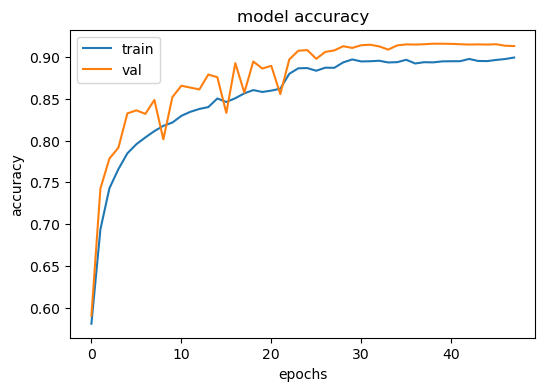

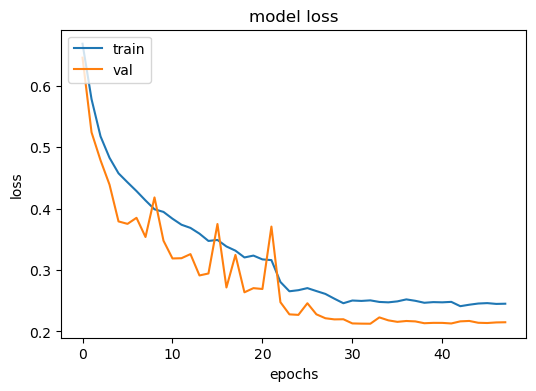

In [129]:
display_plot('accuracy')
display_plot('loss')

## Prepare Testing Data


In [130]:
test_names = os.listdir(r"C:\Users\jiyon\Downloads\dogs-vs-cats\test1\test1")
test_df = pd.DataFrame({
    'filename': test_names
})
test_df

filename
0          1.jpg
1         10.jpg
2        100.jpg
3       1000.jpg
4      10000.jpg
...          ...
12495   9995.jpg
12496   9996.jpg
12497   9997.jpg
12498   9998.jpg
12499   9999.jpg

[12500 rows x 1 columns]

In [131]:
test_df.shape[0]

12500

## Create Testing Generator


In [132]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    r"C:\Users\jiyon\Downloads\dogs-vs-cats\test1\test1\\",
    x_col='filename',
    y_col=None,  # None because its for test generator
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict


In [133]:
predictions = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

  1/834 [..............................] - ETA: 1:37

C:\Users\jiyon\anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


834/834 [==============================] - 30s 36ms/step


In [134]:
predictions.shape

(12500, 2)

In [135]:
test_df['category'] = np.argmax(predictions, axis=-1)


In [136]:
test_df

filename  category
0          1.jpg         1
1         10.jpg         0
2        100.jpg         1
3       1000.jpg         1
4      10000.jpg         1
...          ...       ...
12495   9995.jpg         0
12496   9996.jpg         1
12497   9997.jpg         1
12498   9998.jpg         0
12499   9999.jpg         0

[12500 rows x 2 columns]

In [137]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
print(test_df['category'])
test_df['category'] = test_df['category'].replace(label_map)
test_df['category']


0        1
1        0
2        1
3        1
4        1
        ..
12495    0
12496    1
12497    1
12498    0
12499    0
Name: category, Length: 12500, dtype: int64


0        dog
1        cat
2        dog
3        dog
4        dog
        ... 
12495    cat
12496    dog
12497    dog
12498    cat
12499    cat
Name: category, Length: 12500, dtype: object

<AxesSubplot:>

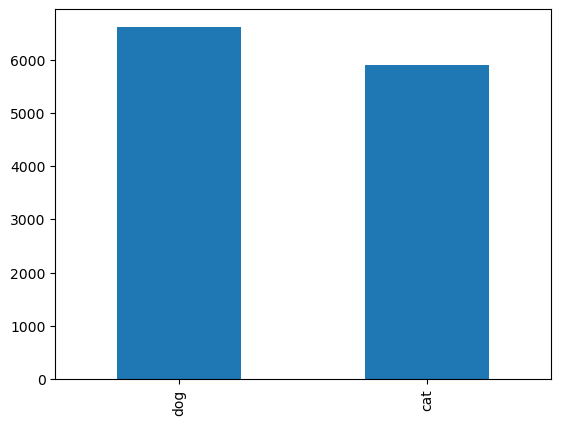

In [138]:
test_df['category'].value_counts().plot.bar()

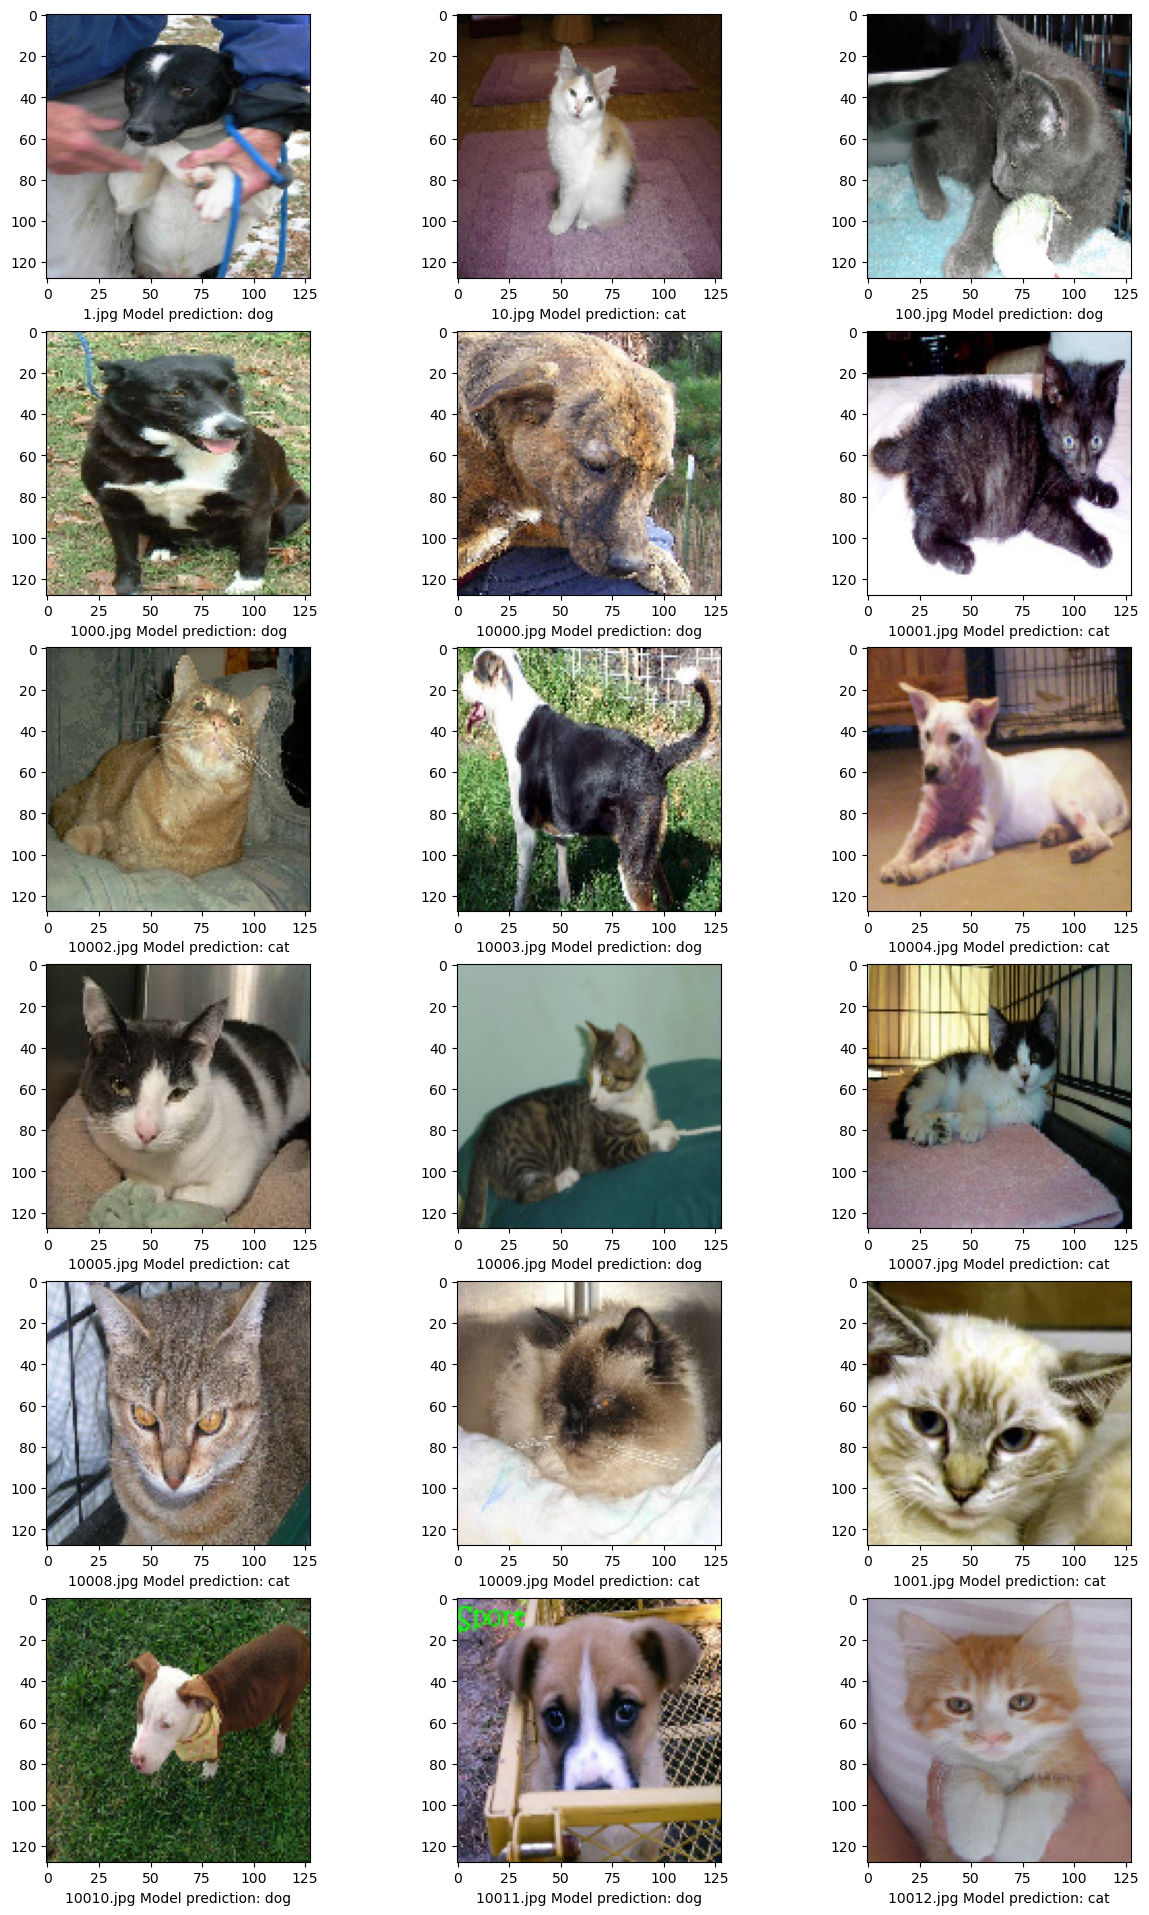

In [139]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(15, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\jiyon\Downloads\dogs-vs-cats\test1\test1\\" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6,3 ,index+1)

    plt.imshow(img)
    plt.xlabel(filename + f" Model prediction: {category}")

plt.show()

In [140]:
15/18

0.8333333333333334

In [141]:
def rescale_img(filepath):
    img = plt.imread(filepath)
    if img.shape[2] == 4:  # 4 channels for png
        img = img[:, :, :3]
        #slice off the alpha channel

    print(img.shape)
    resized = cv2.resize(img, (IMAGE_SIZE))
    resized = np.expand_dims(resized, axis=0)
    return resized
# Test with my own images


In [142]:
def predict_single_img(img):
    predict = model.predict(img)
    print(predict)
    predict = np.argmax(predict, axis=-1)
    return predict

In [143]:
def display_prediction(prediction, filepath):
    category = "dog" if prediction[0] == 1 else "cat"
    plt.figure(figsize=(4, 4))
    img = load_img(filepath, target_size=IMAGE_SIZE)
    plt.imshow(img)
    plt.xlabel(category)

(250, 250, 3)
1/1 [==============================] - 0s 17ms/step
[[0.04179083 0.9582092 ]]


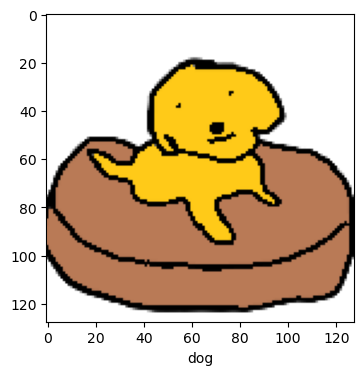

In [144]:
predict_filepath = r"C:\Users\jiyon\Untitled Folder\Cat Dog classifcation\predict\9d2ba2560194d19a55893af33af7ca4a.png"
resized_img = rescale_img(predict_filepath)
prediction = predict_single_img(resized_img)
display_prediction(prediction, predict_filepath)